## 1. Implement the Adam (Batch Version) algorithm to train a multivariable linear regression model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
%matplotlib inline

## Import Data

In [2]:
data2 = np.genfromtxt('/content/MultiVarLR.csv',delimiter=',')

In [3]:
X2 = data2[:, :3]
X2.shape

(25, 3)

In [4]:
y2 = data2[:, -1]
y2.shape

(25,)

## Reshape Data

In [5]:
y2 = y2.reshape((-1, 1))
y2.shape

(25, 1)

In [6]:
m = X2.shape[0]
X2 = np.concatenate((np.ones((m, 1)), X2), axis=1)

In [7]:
X2.shape

(25, 4)

## Adam Function

In [8]:
def adam(X, y, alpha, epsilon, beta1, beta2, epochs):
    cost_vals = []
    thetas = []
    h_s = []

    # 1. Initialize the parameters with zeros
    i = 0
    prev_cost = 0
    m, n = X.shape
    theta = np.zeros((n, 1))
    mt = np.zeros((n, 1))
    vt = np.zeros((n, 1))
    grad = np.ones((n, 1))
    
    while i < epochs and np.linalg.norm(grad, 2) > 0.001:            
        if i > 0:
            prev_cost = cost_vals[-1]

        print(f"****************** Epoch {i} ****************** ")
        
        # 2. Predict the output
        h_x = np.dot(X, theta)
        h_s.append(h_x)

        # 3. Calculate the cost function
        error = h_x - y
        j = (1 / (2 * m)) * np.linalg.norm(error, 2)**2
        print(f'Error Vector: \n{error}')
        print(f'\nj = {j}')
        cost_vals.append(j)

        # 4. Calculate the gradient
        grad = np.dot(X.T, error) / m
        print(f"Gradient Vector: \n{grad}")
        print(f"Gradient Vector Norm: {np.linalg.norm(grad, 2)}")

        # 5. Update the parameters
        mt = beta1 * mt + (1 - beta1) * grad
        mt_hat = mt/(1-beta1**(i+1))
        vt = beta2 * vt + (1-beta2) * grad**2
        vt_hat = vt/(1-beta2**(i+1))
        theta = theta - (alpha/(np.sqrt(vt_hat) + epsilon)) * mt_hat
        
        print(f'theta_new : {theta}')
        thetas.append(theta)
        
        # print(f'thetas : {thetas}')

        # Cost Convergence check
        if i > 1 and abs(prev_cost - cost_vals[-1]) < 0.001:
            break

        i += 1
    
    return thetas[-1], cost_vals, thetas, h_s

In [48]:
theta, cost_vals, thetas, h_s = adam(X2, y2, alpha=0.01, epsilon=1e-08, beta1=0.2, beta2=0.7, epochs=500)

Streaming output truncated to the last 5000 lines.
 [-7247.41111638]
 [-7286.7237182 ]
 [-7470.03087363]]
Gradient Vector Norm: 12705.539725558521
theta_new : [[0.30913297]
 [0.30913093]
 [0.30913026]
 [0.30914543]]
****************** Epoch 32 ****************** 
Error Vector: 
[[ -81.20798136]
 [ -99.98770296]
 [ -96.2242722 ]
 [-104.8049896 ]
 [ -77.08153209]
 [ -53.08393728]
 [ -80.68099577]
 [ -64.30169317]
 [ -95.55209714]
 [ -90.42560776]
 [ -75.15409851]
 [ -76.08147343]
 [ -97.44208202]
 [ -79.97148663]
 [ -79.37184967]
 [-105.75113642]
 [ -78.37199598]
 [-101.07901363]
 [ -94.46085459]
 [ -85.11664508]
 [ -96.93384001]
 [ -95.24298273]
 [ -98.64348165]
 [ -77.58977951]
 [-103.89636802]]

j = 3917.91158671125
Gradient Vector: 
[[  -87.53831589]
 [-7063.08766135]
 [-7101.38549802]
 [-7280.37351113]]
Gradient Vector Norm: 12382.583927507727
theta_new : [[0.31859675]
 [0.31859459]
 [0.31859387]
 [0.31861001]]
****************** Epoch 33 ****************** 
Error Vector: 
[[ -79.04

## Plot loss

In [41]:
def plot_loss_iter(losses, epochs, f_size):
  plt.figure(figsize=f_size)
  plt.plot(losses, epochs, marker='*')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title("plot loss vs iterations")
  plt.show()

def plot_loss_theta(losses, thetas, alpha, i):
  plt.figure(figsize=(10, 10))
  plt.plot(thetas, losses, marker='*')
  plt.xlabel(f'Theta {i}')
  plt.ylabel('Loss')
  plt.title(f"Learning Rate = {alpha}")
  plt.show()

def plot_loss(cost_vals, thetas, alpha, f_size=(10, 10)):
  plot_loss_iter(np.arange(len(cost_vals)), cost_vals, f_size)
  n = thetas[0].shape[0]
  for i in range(n):
    plot_loss_theta(cost_vals, np.array(thetas)[:, i], alpha, i)

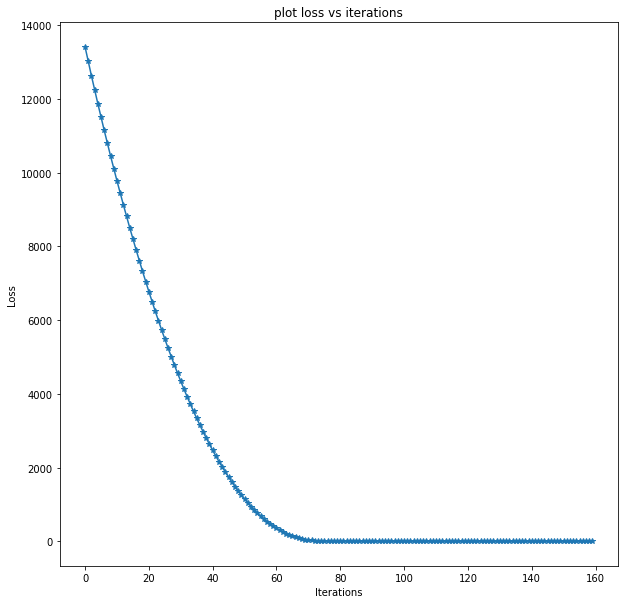

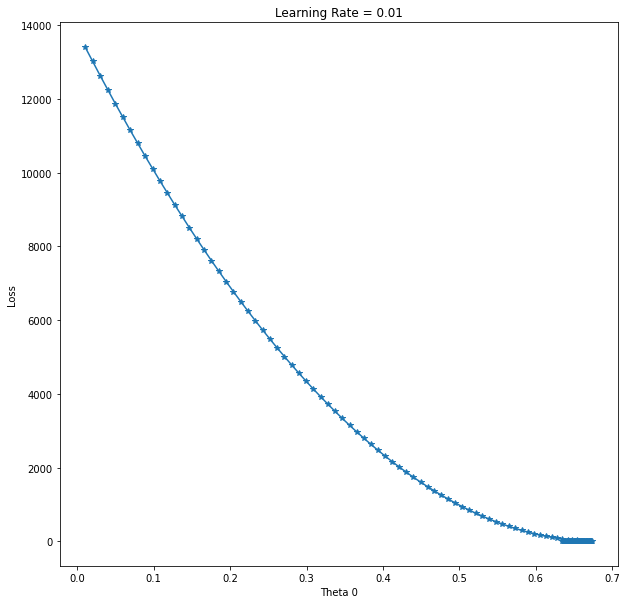

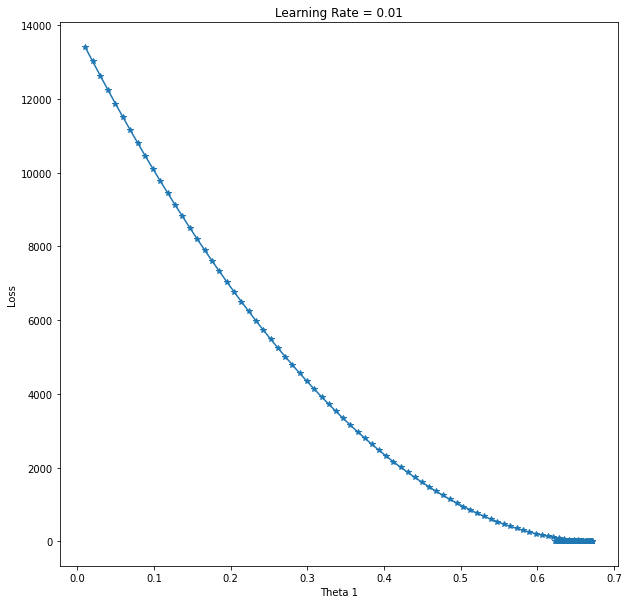

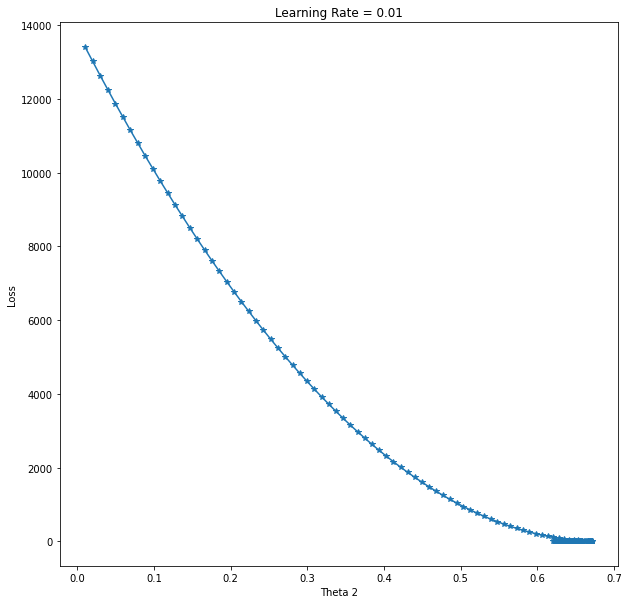

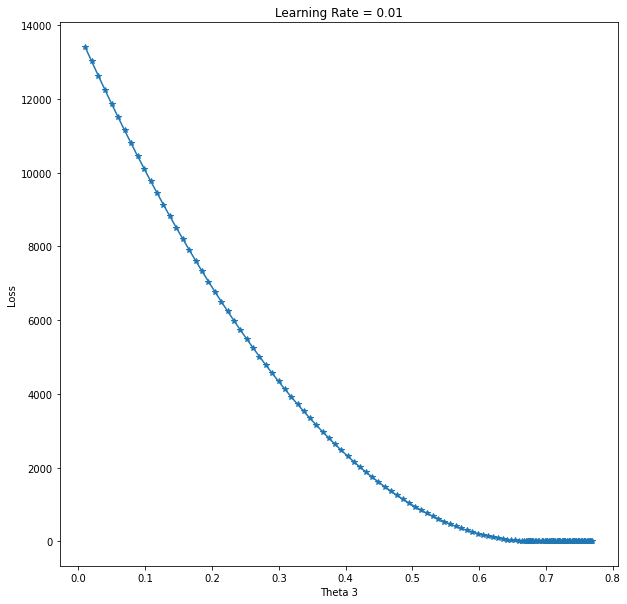

In [49]:
plot_loss(cost_vals, thetas, alpha=0.01)

## R2Score

In [50]:
r2_score(y2,h_s[-1])

0.982090023089159

## 2. BFGS optimizer

In [13]:
def cost_grad(X, y, theta):
    # j = (1 / (2 * m)) * np.linalg.norm(error, 2)**2
    m = X.shape[0]
    h_x = np.dot(X, theta)
    error = h_x - y
    grad = np.dot(X.T, error) / m
    return grad

In [51]:
def calc_cost(X, y, theta):
    m = X.shape[0]
    h_x = np.dot(X, theta)
    error = h_x - y
    j = (1 / (2 * m)) * np.linalg.norm(error, 2)**2
    return j

In [32]:
def BFGS(xk_1, x0, df, X_data, y_data, alpha, epsilon):
  theta_prev = xk_1
  theta = x0
  i = 0
  n = X_data.shape[1]
  I = np.eye(n)
  B_inv = I

  cost_vals = []
  thetas = []

  if x0 is None:
    d_theta = df(X_data, y_data, theta_prev)
    theta = theta_prev - alpha * np.dot(B_inv, d_theta)
    thetas.append(theta)

  while True:
      # Calculate cost
      j = calc_cost(X_data, y_data, theta)
      print('cost: ', j)
      cost_vals.append(j)

      # Calculate the gradient
      d_theta = df(X_data, y_data, theta)
      delta_x = theta - theta_prev

      y = d_theta - df(X_data, y_data, theta_prev)
      
      # calculate each term in the BFGS equation
      den = np.dot(y.T, delta_x)
      t1 = I - np.dot(delta_x, y.T)/den
      t2 = I - np.dot(y, delta_x.T)/den
      t3 = np.dot(delta_x, delta_x.T)/den
      
      # calculate B_inv
      B_inv = np.dot(np.dot(t1, B_inv), t2) + t3
      print('xn_1:\n', theta_prev)
      print('xn:\n', theta)
      print('Dfxn_1:\n', df(X_data, y_data, theta_prev))
      print('Dfxn:\n', df(X_data, y_data, theta))
      print('***************')
      print('B_inv\n', B_inv)
      print('***************')

      if len(cost_vals) > 1 and abs(cost_vals[-2] - cost_vals[-1]) < 0.001:
            break

      if np.linalg.norm(d_theta, 2) < epsilon:
        break

      # Update the parameters
      theta_prev = theta
      theta = theta_prev - alpha * np.dot(B_inv, d_theta)
      thetas.append(theta)
      i += 1
    
  print(f'Found solution after {i} iterations.')
  print(f'xy_min = {theta}')
  print(f'Gradient = {d_theta}')
  return theta, d_theta, i, cost_vals, thetas

## Initialize theta_prev

In [33]:
X2.shape

(25, 4)

In [34]:
y2.shape

(25, 1)

In [35]:
n = X2.shape[1]
xk_1 = np.zeros((n, 1))
xk_1.shape

(4, 1)

In [36]:
xk_1

array([[0.],
       [0.],
       [0.],
       [0.]])

In [37]:
x0 = None

In [43]:
theta, grad, i, cost_vals, thetas = BFGS(xk_1, x0, cost_grad, X2, y2, alpha=1, epsilon=0.001)

cost:  5145882705455.929
xn_1:
 [[0.]
 [0.]
 [0.]
 [0.]]
xn:
 [[  162.04]
 [13075.8 ]
 [13147.2 ]
 [13467.08]]
Dfxn_1:
 [[  -162.04]
 [-13075.8 ]
 [-13147.2 ]
 [-13467.08]]
Dfxn:
 [[3.17574837e+06]
 [2.56317967e+08]
 [2.57728446e+08]
 [2.63739883e+08]]
***************
B_inv
 [[ 0.99995    -0.00403566 -0.00405787 -0.00415252]
 [-0.00403566  0.67427736 -0.32751504 -0.33515433]
 [-0.00405787 -0.32751504  0.6706827  -0.33699864]
 [-0.00415252 -0.33515433 -0.33699864  0.65514118]]
***************
cost:  1019.922300398132
xn_1:
 [[  162.04]
 [13075.8 ]
 [13147.2 ]
 [13467.08]]
xn:
 [[-0.00961902]
 [-3.39396216]
 [-3.96679272]
 [ 9.16625244]]
Dfxn_1:
 [[3.17574837e+06]
 [2.56317967e+08]
 [2.57728446e+08]
 [2.63739883e+08]]
Dfxn:
 [[   1.27717517]
 [ -50.57355074]
 [-117.41129038]
 [ 163.71079594]]
***************
B_inv
 [[ 0.99995    -0.00403566 -0.00405787 -0.00415252]
 [-0.00403566  0.67427723 -0.32751525 -0.33515419]
 [-0.00405787 -0.32751525  0.6706824  -0.33699859]
 [-0.00415252 -0.33515

## plots

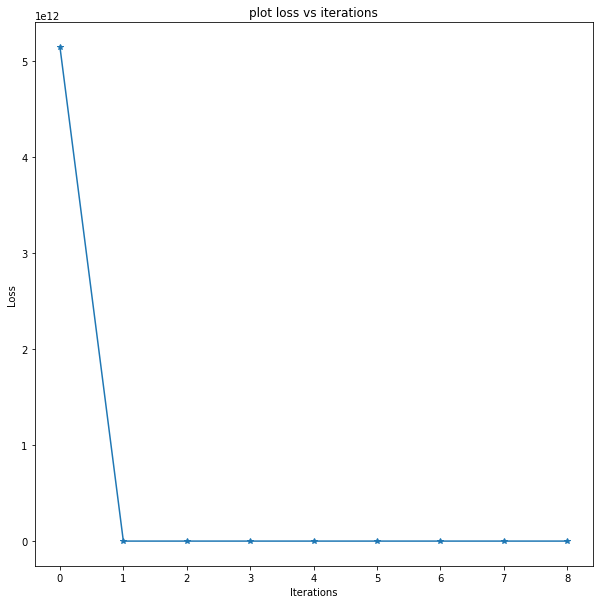

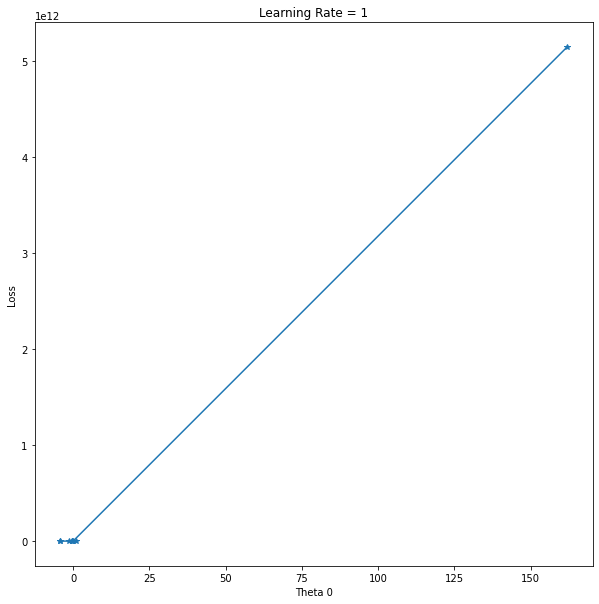

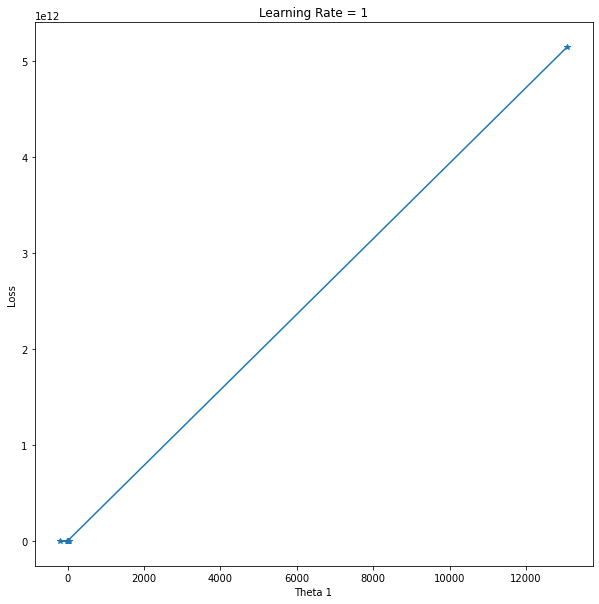

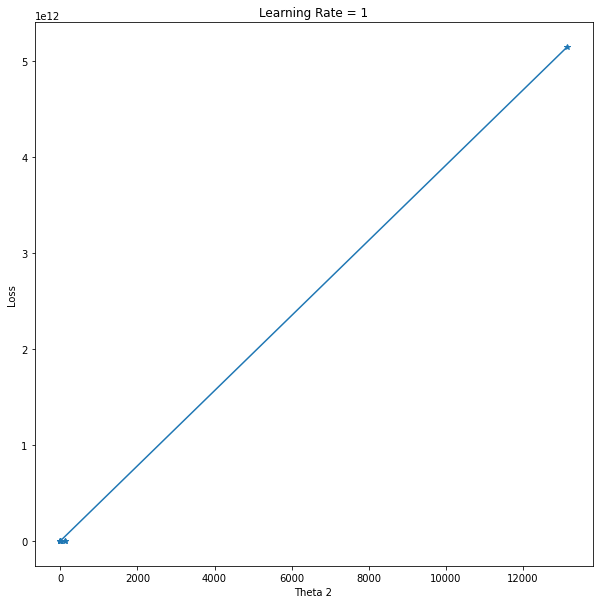

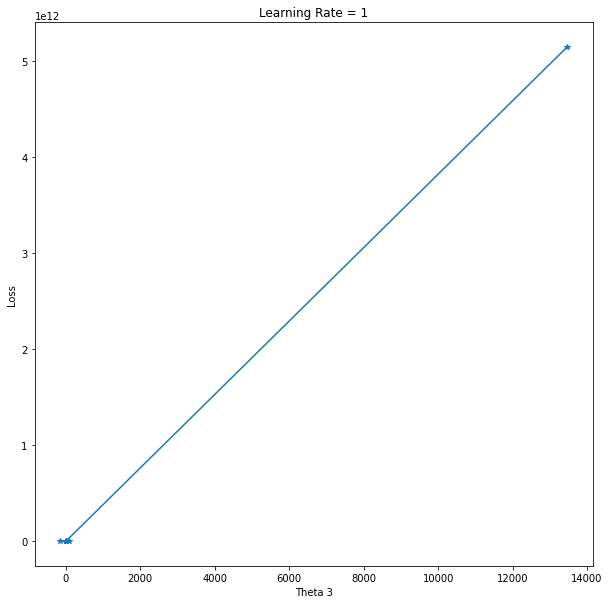

In [44]:
plot_loss(cost_vals, thetas, alpha=1)

## R2Score

In [45]:
h_x = np.dot(X2, theta)
r2_score(y2,h_x)

0.9896615775501718

# Conclusion

|Alogrithm|R2_score|Epochs|
|---------|:-------|:-----|
|Adam     |0.9821  |159   |
|BFGS     |0.9897  |8     |

BFGS was able to converge faster than Adam, as it only needed 8 iterations and actually got better accuracy although the difference is minimum.

Since we are optimizing a convex function, then second order optimization will overbeat the first order optimization.
Also, the BFGS solves the cost of computationaly expensive operation of the inverse of hessian matrix by dependeing on the previous first derivative.

So both algorithms reach a pretty good accuracy, but BFGS is much faster.